In [1]:
!pip install haversine
!pip install imbalanced-learn

In [2]:
# Import libraries
import math
import folium
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2
from matplotlib.pyplot import xticks
from haversine import haversine
from datetime import datetime
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline
from numpy import where
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, confusion_matrix, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import classification_report, precision_score, accuracy_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from geopy.geocoders import Nominatim

# Importing required packages for visualization
from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import pydotplus, graphviz

In [3]:
# Display all columns
pd.set_option('display.max_columns',200)

## Reading and Understanding Data

In [4]:
data = pd.read_csv('drive/MyDrive/DSA4266/train.csv')

data.shape

(567545, 11)

In [5]:
# See how the data looks like

data.head()

,order_id,service_type,driver_status,date,hour,seconds,latitude,longitude,altitude_in_meters,accuracy_in_meters,label
0,RB193,GO_RIDE,UNAVAILABLE,2018-02-05,6,1548890667,-6.922910,107.631301,NaN,23.027,0
1,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890680,-6.923039,107.631250,712.0,9.577,0
2,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890690,-6.923039,107.631250,712.0,9.577,0
3,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890700,-6.923048,107.631230,713.0,8.139,0
4,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890710,-6.922968,107.631253,713.0,7.029,0


In [6]:
encoded_columns = pd.get_dummies(data[['service_type', 'driver_status']], prefix=['service_type', 'driver_status'])

# Concatenate the original DataFrame with the encoded columns
data = pd.concat([data, encoded_columns], axis=1)

In [7]:
data.head()

,order_id,service_type,driver_status,date,hour,seconds,latitude,longitude,altitude_in_meters,accuracy_in_meters,label,service_type_GO_FOOD,service_type_GO_RIDE,driver_status_AVAILABLE,driver_status_OTW_DROPOFF,driver_status_OTW_PICKUP,driver_status_UNAVAILABLE
0,RB193,GO_RIDE,UNAVAILABLE,2018-02-05,6,1548890667,-6.922910,107.631301,NaN,23.027,0,False,True,False,False,False,True
1,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890680,-6.923039,107.631250,712.0,9.577,0,False,True,True,False,False,False
2,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890690,-6.923039,107.631250,712.0,9.577,0,False,True,True,False,False,False
3,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890700,-6.923048,107.631230,713.0,8.139,0,False,True,True,False,False,False
4,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890710,-6.922968,107.631253,713.0,7.029,0,False,True,True,False,False,False


## Correlation heatmap to find out columns that are similar

## Driver Status vs Accuracy of ping across different services

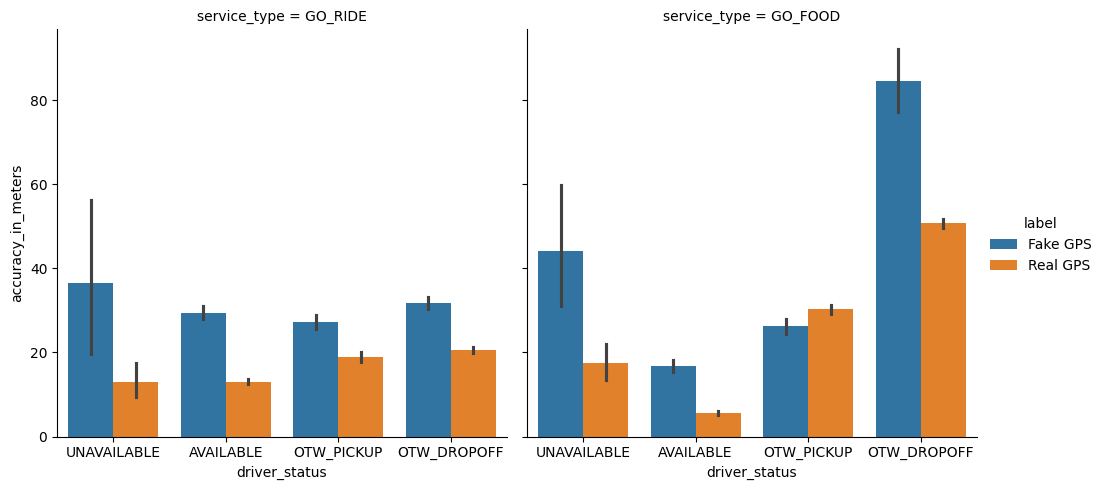

In [9]:
# Create a copy of the original DataFrame
data2 = data.copy()

# Define the mapping for label replacement
label_mapping = {0: 'Fake GPS', 1: 'Real GPS'}

# Replace the labels in the 'label' column
data2['label'] = data2['label'].replace(label_mapping)

sns.catplot(data=data2, x='driver_status', y='accuracy_in_meters', hue='label', col='service_type', kind='bar')

## Count of Service Types for Unique Order IDs

In [10]:
unique_order_ids = data['order_id'].unique()
unique_order_ids, len(unique_order_ids)

(array(['RB193', 'F1452', 'F943', ..., 'RB88', 'RB1812', 'RB261'],
       dtype=object),
 3500)

<ipython-input-11-0b1c267d5fb1>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='service_type', data=filtered_df, palette=color_map)


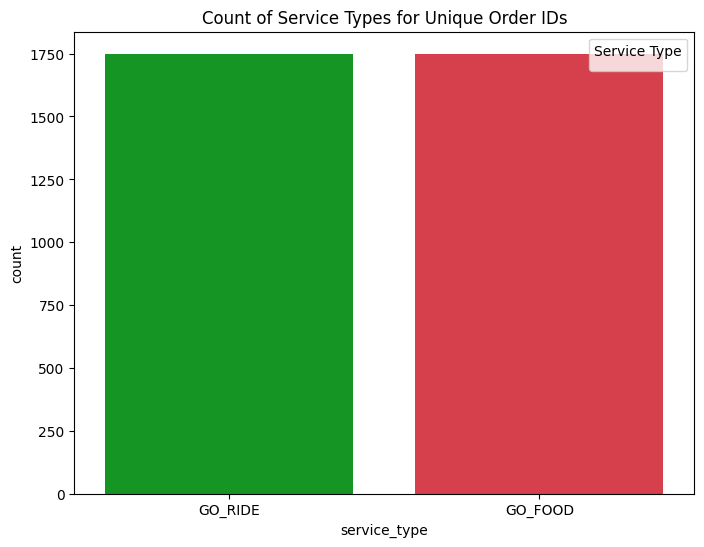

In [11]:
# Filter the DataFrame based on unique order IDs
filtered_df = data[data['order_id'].isin(unique_order_ids)]
filtered_df = filtered_df.drop_duplicates(subset='order_id', keep='first')

# Create a count plot for 'service_type'
color_map = {'GO_RIDE': '#00AA13', 'GO_FOOD': '#ee2737'}
plt.figure(figsize=(8, 6))
sns.countplot(x='service_type', data=filtered_df, palette=color_map)
plt.title('Count of Service Types for Unique Order IDs')
plt.legend(title='Service Type')
plt.show()

## Distribution of Fake vs Real IDs across different service types

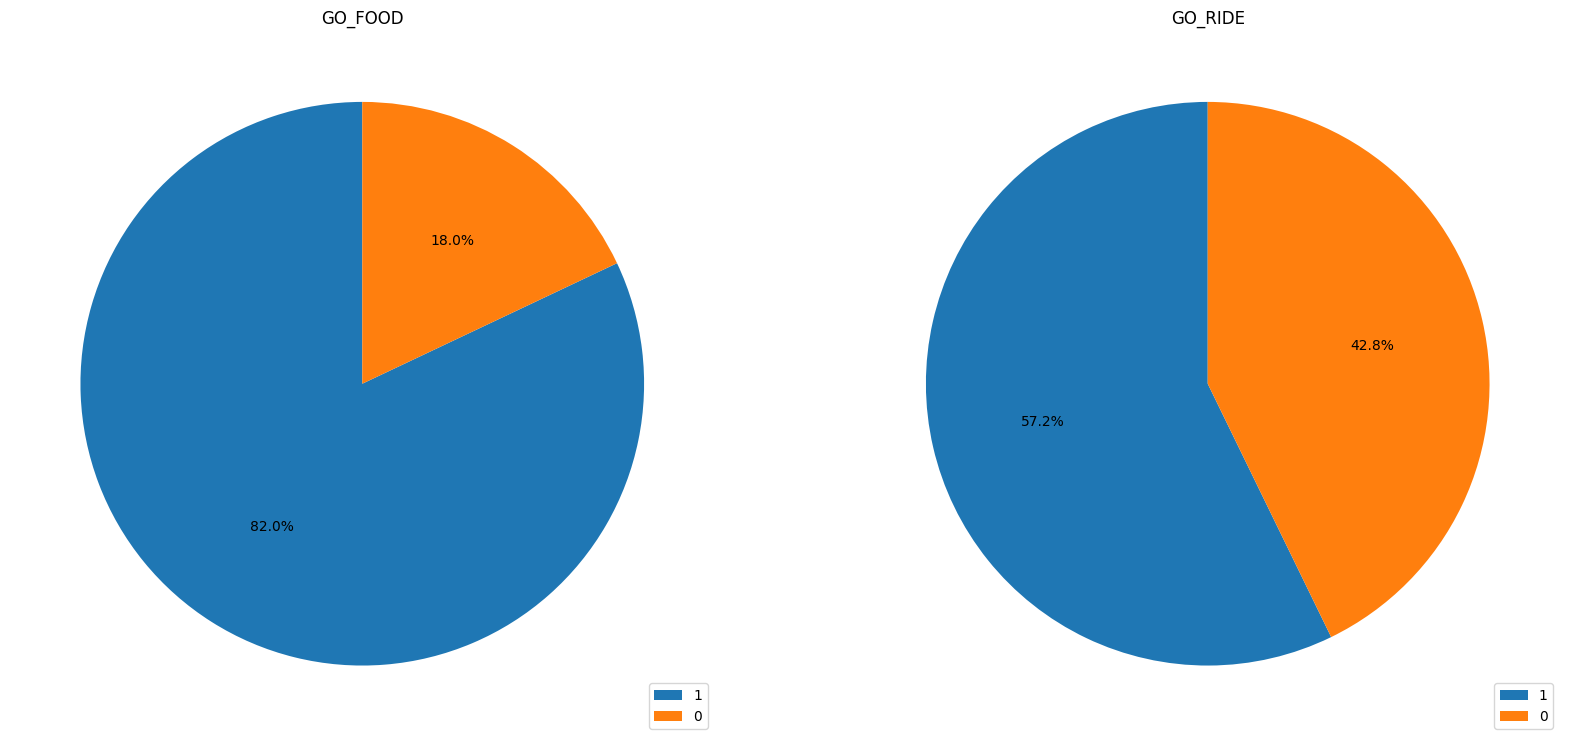

In [12]:
# Function to plot distribution
def plot_service_type_pie(variable):

    # Plot on a pie chart
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,20))


    data_0 = data[data.service_type=="GO_FOOD"][variable].value_counts()
    labels = data_0.index
    ax1.pie(data_0, autopct='%1.1f%%',startangle=90)
    ax1.set_title('GO_FOOD')
    ax1.legend(labels, loc="lower right")

    data_1 = data[data.service_type=="GO_RIDE"][variable].value_counts()
    labels = data_1.index
    ax2.pie(data_1, autopct='%1.1f%%', startangle=90)
    ax2.set_title('GO_RIDE')

    ax2.legend(labels, loc="lower right")

    plt.show()

# Plot on a pie chart
plot_service_type_pie("label")

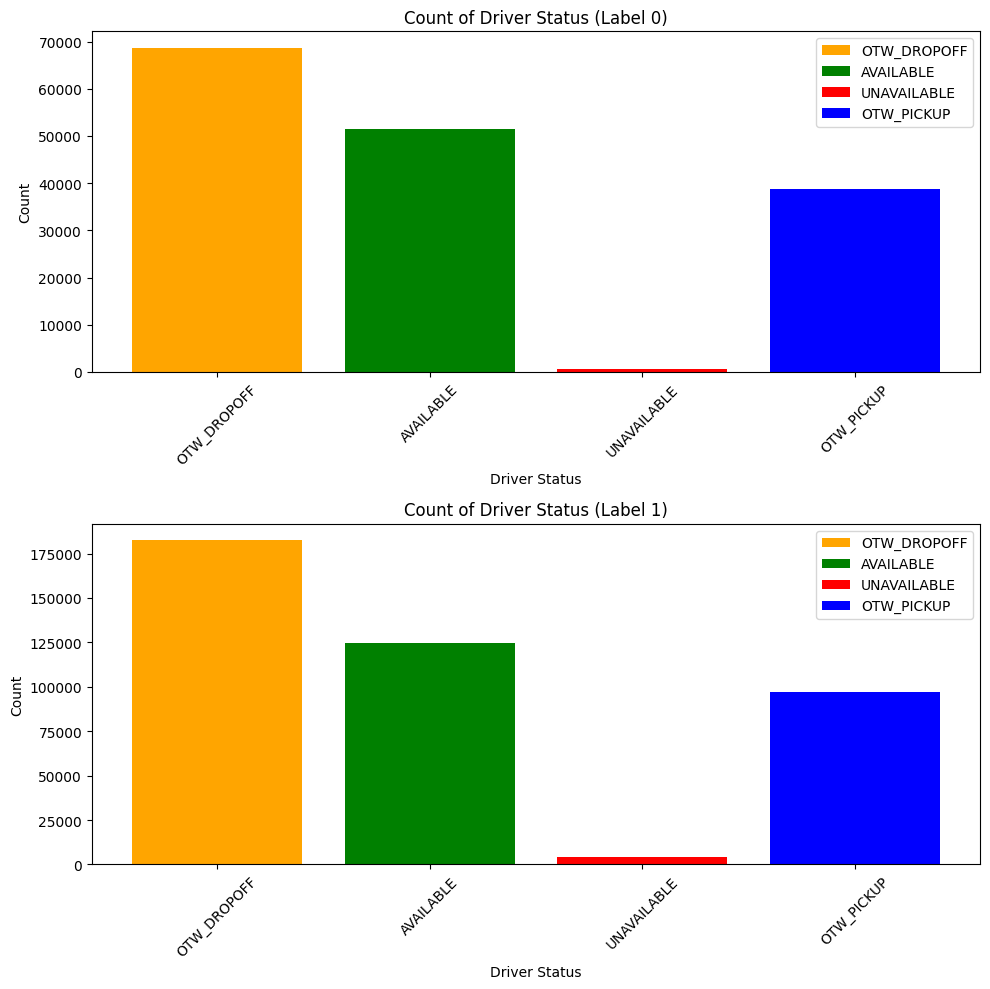

In [13]:
filtered_df_label_0 = data[data['label'] == 0]

# Filter DataFrame where label == 1
filtered_df_label_1 = data[data['label'] == 1]

# Define colors for each driver status
color_mapping = {
    'OTW_DROPOFF': 'orange',
    'AVAILABLE': 'green',
    'UNAVAILABLE': 'red',
    'OTW_PICKUP': 'blue'
}

# Plot count based on driver_status for label 0
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
for i, (status, color) in enumerate(color_mapping.items()):
    counts = filtered_df_label_0[filtered_df_label_0['driver_status'] == status]['driver_status'].value_counts()
    labels = [f'{status}: {count}' for count in counts]
    plt.bar([i], counts, color=color, label=status)
plt.title('Count of Driver Status (Label 0)')
plt.xlabel('Driver Status')
plt.ylabel('Count')
plt.xticks(range(len(color_mapping)), color_mapping.keys(), rotation=45)
plt.legend()

# Plot count based on driver_status for label 1
plt.subplot(2, 1, 2)
for i, (status, color) in enumerate(color_mapping.items()):
    counts = filtered_df_label_1[filtered_df_label_1['driver_status'] == status]['driver_status'].value_counts()
    labels = [f'{status}: {count}' for count in counts]
    plt.bar([i], counts, color=color, label=status)
plt.title('Count of Driver Status (Label 1)')
plt.xlabel('Driver Status')
plt.ylabel('Count')
plt.xticks(range(len(color_mapping)), color_mapping.keys(), rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

Note that distribution of pings across different `driver_status` is quite similar for both fake and real order IDs

## Distribution of driver status across different service types

<Axes: xlabel='service_type'>

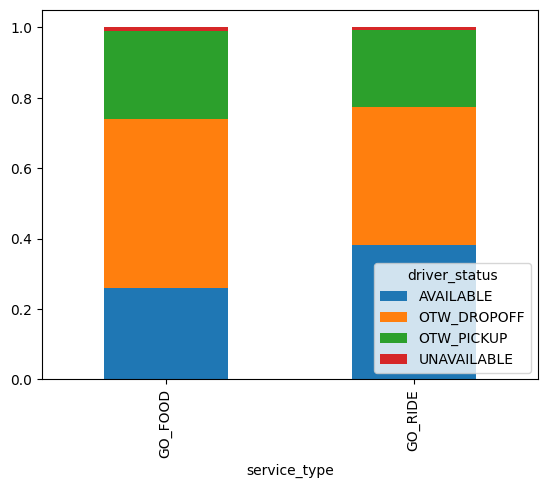

In [14]:
data.groupby('service_type')['driver_status'].value_counts(normalize=True).unstack('driver_status').plot.bar(stacked=True)

`GO_RIDE` service spends more time `AVAILABLE` than the `GO_FOOD` service

## Visualise an `order_id` on the map

In [15]:
def plot_folium(df, label, lat_column, lon_column, zoom_start=10, order_id=None):
    # Filter DataFrame by label
    df = df[df['label'] == label]

    # If order_id is not provided, select a random order_id from the filtered DataFrame
    if order_id is None:
        order_ids = df['order_id'].unique()
        if len(order_ids) == 0:
            print("No orders found for the given label.")
            return
        order_id = random.choice(order_ids)

    # Select subset of dataframe by order ID
    df = df[df['order_id'] == order_id]

    # Calculate the center of the map
    center_lat = df[lat_column].mean()
    center_lon = df[lon_column].mean()

    # Folium plot
    my_map = folium.Map(location=[center_lat, center_lon], zoom_start=zoom_start)

    # Define different colors for status and corresponding labels
    color_mapping = {
        'UNAVAILABLE': 'red',
        'AVAILABLE': 'green',
        'OTW_PICKUP': 'black',
        'OTW_DROPOFF': 'blue'
    }

    # Add markers to the map
    for index, row in df.iterrows():
        color = color_mapping.get(row['driver_status'], 'gray')
        popup_text = f"Latitude: {row[lat_column]}<br>Longitude: {row[lon_column]}<br>Status: {row['driver_status']}"
        popup = folium.Popup(popup_text, parse_html=True)
        folium.CircleMarker(
            location=[row[lat_column], row[lon_column]],
            radius=3,
            color=color,
            fill=True,
            fill_color=color,
            popup=popup
        ).add_to(my_map)

    # Add legend to the map
    legend_html = '''
    <div style="position: fixed;
                 bottom: 30px; left: 50px; width: 150px; height: 120px;
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color: white;
    ">&nbsp; <b>Legend</b> <br>'''
    for status, color in color_mapping.items():
        legend_html += f'&nbsp; <i class="fa fa-circle" style="color:{color}"></i> {status}<br>'
    legend_html += '</div>'
    my_map.get_root().html.add_child(folium.Element(legend_html))

    return my_map

In [16]:
fake_map = plot_folium(data, label=0, lat_column='latitude', lon_column='longitude',zoom_start=13)
display(fake_map)

## Plotting an `order_id` with REAL GPS

In [17]:
real_map = plot_folium(data, label=1, lat_column='latitude', lon_column='longitude',zoom_start=13)
display(real_map)

# Feature Engineering

## Counting pings with `UNAVAILABLE driver_status` for each `order_id`

In [18]:
# Group by 'order_id' and sort by 'seconds' within each group
df_sorted = data.groupby('order_id').apply(lambda x: x.sort_values('seconds')).reset_index(drop=True)

df_sorted['unavailable_count'] = df_sorted.groupby('order_id')['driver_status'].transform(lambda x: (x == 'UNAVAILABLE').sum())

## Calculate time difference between consecutive pings for each id

In [19]:
# Calculate time difference between consecutive rows of 'seconds' within each group
df_sorted['time_diff_seconds'] = df_sorted.groupby('order_id')['seconds'].diff()

In [20]:
df_sorted

,order_id,service_type,driver_status,date,hour,seconds,latitude,longitude,altitude_in_meters,accuracy_in_meters,label,service_type_GO_FOOD,service_type_GO_RIDE,driver_status_AVAILABLE,driver_status_OTW_DROPOFF,driver_status_OTW_PICKUP,driver_status_UNAVAILABLE,unavailable_count,time_diff_seconds
0,F0,GO_FOOD,AVAILABLE,2018-03-02,10,1551065855,-6.874573,107.604420,856.600000,0.100,1,True,False,True,False,False,False,2,NaN
1,F0,GO_FOOD,AVAILABLE,2018-03-02,10,1551065865,-6.874573,107.604420,856.600000,0.100,1,True,False,True,False,False,False,2,10.0
2,F0,GO_FOOD,AVAILABLE,2018-03-02,10,1551065875,-6.874573,107.604420,848.500000,0.100,1,True,False,True,False,False,False,2,10.0
3,F0,GO_FOOD,AVAILABLE,2018-03-02,10,1551065885,-6.874573,107.604420,848.500000,0.100,1,True,False,True,False,False,False,2,10.0
4,F0,GO_FOOD,AVAILABLE,2018-03-02,10,1551065895,-6.874573,107.604420,844.800000,0.100,1,True,False,True,False,False,False,2,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567540,RB999,GO_RIDE,AVAILABLE,2018-02-21,8,1550280725,-6.917615,107.598171,733.232910,3.279,0,False,True,True,False,False,False,1,10.0
567541,RB999,GO_RIDE,AVAILABLE,2018-02-21,8,1550280734,-6.917615,107.598171,733.232910,3.279,0,False,True,True,False,False,False,1,9.0
567542,RB999,GO_RIDE,UNAVAILABLE,2018-02-21,8,1550280736,-6.917611,107.598180,733.491089,3.000,0,False,True,False,False,False,True,1,2.0
567543,RB999,GO_RIDE,AVAILABLE,2018-02-21,8,1550280748,-6.917614,107.598182,733.690430,3.000,0,False,True,True,False,False,False,1,12.0


## Calculate distances between consecutive pings of each `order_id`

In [21]:
# Haversine formula to calculate distance between two points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # radius of the Earth in km

    # Convert latitude and longitude from degrees to radians
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    # Calculate the change in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Calculate distance using Haversine formula
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

# Calculate distance between consecutive rows
def calculate_distance(group):
    prev_lat = group['latitude'].shift()
    prev_lon = group['longitude'].shift()
    distances = []
    for idx, row in group.iterrows():
        if not pd.isna(prev_lat[idx]) and not pd.isna(prev_lon[idx]):
            distance = haversine(row['latitude'], row['longitude'], prev_lat[idx], prev_lon[idx])
            distances.append(distance)
        else:
            distances.append(None)
    return distances


In [22]:
# Group by order_id and calculate distance
df_sorted['distance'] = df_sorted.groupby('order_id').apply(calculate_distance).explode().reset_index(drop=True)

## Calculate speed using distance and time_diff_seconds for consecutive pings of each `order_id`

In [23]:
# Fill NaN values in time_diff_seconds with 0
df_sorted['time_diff_seconds'].fillna(0, inplace=True)

# Replace None values in distance column with 0
df_sorted['distance'].fillna(0, inplace=True)

# Calculate speed (velocity) by dividing distance by time difference
df_sorted['speed'] = 0  # Initialize speed column with zeros
non_zero_mask = (df_sorted['time_diff_seconds'] != 0) & (df_sorted['distance'] != 0)
df_sorted.loc[non_zero_mask, 'speed'] = df_sorted['distance'] / (df_sorted['time_diff_seconds'] / 3600)

## Calculate latitude and longitude difference for consecutive pings of each `order_id`

In [24]:
# Group by 'order_id' and calculate differences in latitude and longitude
df_grouped = df_sorted.groupby('order_id')
df_sorted['lat_diff'] = df_grouped['latitude'].diff()
df_sorted['lon_diff'] = df_grouped['longitude'].diff()

## Calculate change in latitude and longitude per second for consecutive pings of each order_id

In [25]:
# Calculate rates of change in latitude and longitude (degrees per second)
df_sorted['lat_rate'] = df_sorted['lat_diff'] / df_sorted['time_diff_seconds']
df_sorted['lon_rate'] = df_sorted['lon_diff'] / df_sorted['time_diff_seconds']

## Calculate geospatial aggregates using latitude and longitude columns to derive mean, median, min, max, count

In [26]:
# Group by 'order_id' and compute geospatial aggregates
geospatial_aggregates = df_sorted.groupby('order_id').agg({
    'latitude': ['mean', 'median', 'min', 'max', 'count'],  # Example aggregates for latitude
    'longitude': ['mean', 'median', 'min', 'max', 'count'],  # Example aggregates for longitude
    # Add more columns and corresponding aggregate functions as needed
})

# Flatten multi-level column index
geospatial_aggregates.columns = ['_'.join(col) for col in geospatial_aggregates.columns]

# Merge aggregates with original DataFrame
df_sorted = df_sorted.merge(geospatial_aggregates, how='left', on='order_id')

## Calculate speed aggregates using speed column to derive mean, median, min, max

In [27]:
# Group by 'order_id' and compute speed aggregates for speed
speed_aggregates = df_sorted.groupby('order_id').agg({
    'speed': ['mean', 'median', 'min', 'max'],  # Example aggregates for speed
    # Add more columns and corresponding aggregate functions as needed
})

# Flatten multi-level column index
speed_aggregates.columns = ['_'.join(col) for col in speed_aggregates.columns]

# Merge aggregates with original DataFrame
df_sorted = df_sorted.merge(speed_aggregates, how='left', on='order_id')

## Calculate distance aggregates using distance column to derive mean, median, min, max, count

In [28]:
# Group by 'order_id' and compute distance aggregates for speed
distance_aggregates = df_sorted.groupby('order_id').agg({
    'distance': ['mean', 'median', 'min', 'max'],  # Example aggregates for speed
    # Add more columns and corresponding aggregate functions as needed
})

# Flatten multi-level column index
distance_aggregates.columns = ['_'.join(col) for col in distance_aggregates.columns]

# Merge aggregates with original DataFrame
df_sorted = df_sorted.merge(distance_aggregates, how='left', on='order_id')

## Calculate accuracy aggregates using accuracy_in_meters column to derive mean, median, min, max

In [29]:
# Group by 'order_id' and compute geospatial aggregates for speed
acc_aggregates = df_sorted.groupby('order_id').agg({
    'accuracy_in_meters': ['mean', 'median', 'min', 'max'],  # Example aggregates for speed
    # Add more columns and corresponding aggregate functions as needed
})

# Flatten multi-level column index
acc_aggregates.columns = ['_'.join(col) for col in acc_aggregates.columns]

# Merge aggregates with original DataFrame
df_sorted = df_sorted.merge(acc_aggregates, how='left', on='order_id')

## Calculate time difference aggregates using time_diff_seconds column to derive mean, median, min, max

In [30]:
# Group by 'order_id' and compute time_diff aggregates for speed
time_diff_aggregates = df_sorted.groupby('order_id').agg({
    'time_diff_seconds': ['mean', 'median', 'min', 'max'],  # Example aggregates for speed
    # Add more columns and corresponding aggregate functions as needed
})

# Flatten multi-level column index
time_diff_aggregates.columns = ['_'.join(col) for col in time_diff_aggregates.columns]

# Merge aggregates with original DataFrame
df_sorted = df_sorted.merge(time_diff_aggregates, how='left', on='order_id')

## Calculate latitude rate aggregates using lat_rate column to derive mean, median, min, max

In [31]:
# Group by 'order_id' and compute time_diff aggregates for speed
lat_rate_aggregates = df_sorted.groupby('order_id').agg({
    'lat_rate': ['mean', 'median', 'min', 'max'],  # Example aggregates for speed
    # Add more columns and corresponding aggregate functions as needed
})

# Flatten multi-level column index
lat_rate_aggregates.columns = ['_'.join(col) for col in lat_rate_aggregates.columns]

# Merge aggregates with original DataFrame
df_sorted = df_sorted.merge(lat_rate_aggregates, how='left', on='order_id')

## Calculate lon_rate aggregates using longitude_rate column to derive mean, median, min, max

In [32]:
# Group by 'order_id' and compute time_diff aggregates for speed
lon_rate_aggregates = df_sorted.groupby('order_id').agg({
    'lon_rate': ['mean', 'median', 'min', 'max'],  # Example aggregates for speed
    # Add more columns and corresponding aggregate functions as needed
})

# Flatten multi-level column index
lon_rate_aggregates.columns = ['_'.join(col) for col in lon_rate_aggregates.columns]

# Merge aggregates with original DataFrame
df_sorted = df_sorted.merge(lon_rate_aggregates, how='left', on='order_id')

## Calculate otw_pickup_time using the time difference between the first and the last ping when driver status is OTW_PICKUP

In [33]:
# Group by 'order_id'
grouped_df = df_sorted.groupby('order_id')

# Initialize an empty dictionary to store the results
otw_pickup_times = {}

# Iterate over each group
for order_id, group_df in grouped_df:
    # Filter rows with driver_status equal to 'OTW_PICKUP'
    otw_pickup_df = group_df[group_df['driver_status'] == 'OTW_PICKUP']

    # Check if there are at least two rows with 'OTW_PICKUP' status
    if len(otw_pickup_df) >= 2:
        # Calculate the time difference between the last and first value in the 'seconds' column
        time_difference = otw_pickup_df['seconds'].iloc[-1] - otw_pickup_df['seconds'].iloc[0]

        # Store the time difference in the dictionary
        otw_pickup_times[order_id] = time_difference
    else:
        # If there are fewer than two rows with 'OTW_PICKUP' status, store NaN
        otw_pickup_times[order_id] = np.nan

# Convert the dictionary to a DataFrame
otw_pickup_times_df = pd.DataFrame.from_dict(otw_pickup_times, orient='index', columns=['otw_pickup_time'])

# Reset the index to have 'order_id' as a column
otw_pickup_times_df.reset_index(inplace=True)
otw_pickup_times_df.rename(columns={'index': 'order_id'}, inplace=True)

# Merge otw_pickup_times_df with the original DataFrame
merged_df = df_sorted.merge(otw_pickup_times_df, on='order_id', how='left')

## Calculate otw_pickup_time aggregates using otw_pickup_time column to derive mean, median, min, max

In [34]:
# Group by 'order_id' and compute otw_pickup aggregates for speed
otwpickup_aggregates = merged_df.groupby('order_id').agg({
    'otw_pickup_time': ['mean', 'median', 'min', 'max'],  # Example aggregates for speed
    # Add more columns and corresponding aggregate functions as needed
})

# Flatten multi-level column index
otwpickup_aggregates.columns = ['_'.join(col) for col in otwpickup_aggregates.columns]

# Merge aggregates with original DataFrame
merged_df = merged_df.merge(otwpickup_aggregates, how='left', on='order_id')

In [35]:
merged_df.head()

,order_id,service_type,driver_status,date,hour,seconds,latitude,longitude,altitude_in_meters,accuracy_in_meters,label,service_type_GO_FOOD,service_type_GO_RIDE,driver_status_AVAILABLE,driver_status_OTW_DROPOFF,driver_status_OTW_PICKUP,driver_status_UNAVAILABLE,unavailable_count,time_diff_seconds,distance,speed,lat_diff,lon_diff,lat_rate,lon_rate,latitude_mean,latitude_median,latitude_min,latitude_max,latitude_count,longitude_mean,longitude_median,longitude_min,longitude_max,longitude_count,speed_mean,speed_median,speed_min,speed_max,distance_mean,distance_median,distance_min,distance_max,accuracy_in_meters_mean,accuracy_in_meters_median,accuracy_in_meters_min,accuracy_in_meters_max,time_diff_seconds_mean,time_diff_seconds_median,time_diff_seconds_min,time_diff_seconds_max,lat_rate_mean,lat_rate_median,lat_rate_min,lat_rate_max,lon_rate_mean,lon_rate_median,lon_rate_min,lon_rate_max,otw_pickup_time,otw_pickup_time_mean,otw_pickup_time_median,otw_pickup_time_min,otw_pickup_time_max
0,F0,GO_FOOD,AVAILABLE,2018-03-02,10,1551065855,-6.874573,107.60442,856.6,0.1,1,True,False,True,False,False,False,2,0.0,0.0,0.0,NaN,NaN,NaN,NaN,-6.876199,-6.874607,-6.881138,-6.870253,222,107.604297,107.60442,107.603595,107.60564,222,4.563838,0.0,0.0,428.459153,0.014404,0.0,0.0,1.124001,2.55059,0.1,0.1,8.292,10.054054,10.0,0.0,44.0,-0.000001,0.0,-0.001069,0.000089,1.780660e-07,0.0,-0.00006,0.000025,341.0,341.0,341.0,341.0,341.0
1,F0,GO_FOOD,AVAILABLE,2018-03-02,10,1551065865,-6.874573,107.60442,856.6,0.1,1,True,False,True,False,False,False,2,10.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.876199,-6.874607,-6.881138,-6.870253,222,107.604297,107.60442,107.603595,107.60564,222,4.563838,0.0,0.0,428.459153,0.014404,0.0,0.0,1.124001,2.55059,0.1,0.1,8.292,10.054054,10.0,0.0,44.0,-0.000001,0.0,-0.001069,0.000089,1.780660e-07,0.0,-0.00006,0.000025,341.0,341.0,341.0,341.0,341.0
2,F0,GO_FOOD,AVAILABLE,2018-03-02,10,1551065875,-6.874573,107.60442,848.5,0.1,1,True,False,True,False,False,False,2,10.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.876199,-6.874607,-6.881138,-6.870253,222,107.604297,107.60442,107.603595,107.60564,222,4.563838,0.0,0.0,428.459153,0.014404,0.0,0.0,1.124001,2.55059,0.1,0.1,8.292,10.054054,10.0,0.0,44.0,-0.000001,0.0,-0.001069,0.000089,1.780660e-07,0.0,-0.00006,0.000025,341.0,341.0,341.0,341.0,341.0
3,F0,GO_FOOD,AVAILABLE,2018-03-02,10,1551065885,-6.874573,107.60442,848.5,0.1,1,True,False,True,False,False,False,2,10.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.876199,-6.874607,-6.881138,-6.870253,222,107.604297,107.60442,107.603595,107.60564,222,4.563838,0.0,0.0,428.459153,0.014404,0.0,0.0,1.124001,2.55059,0.1,0.1,8.292,10.054054,10.0,0.0,44.0,-0.000001,0.0,-0.001069,0.000089,1.780660e-07,0.0,-0.00006,0.000025,341.0,341.0,341.0,341.0,341.0
4,F0,GO_FOOD,AVAILABLE,2018-03-02,10,1551065895,-6.874573,107.60442,844.8,0.1,1,True,False,True,False,False,False,2,10.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.876199,-6.874607,-6.881138,-6.870253,222,107.604297,107.60442,107.603595,107.60564,222,4.563838,0.0,0.0,428.459153,0.014404,0.0,0.0,1.124001,2.55059,0.1,0.1,8.292,10.054054,10.0,0.0,44.0,-0.000001,0.0,-0.001069,0.000089,1.780660e-07,0.0,-0.00006,0.000025,341.0,341.0,341.0,341.0,341.0


In [36]:
train = merged_df[
    [
        "order_id",
        "service_type_GO_FOOD",
        "service_type_GO_RIDE",
        "driver_status_AVAILABLE",
        "driver_status_OTW_DROPOFF",
        "driver_status_OTW_PICKUP",
        "driver_status_UNAVAILABLE",
        "label",
        "unavailable_count",
        "latitude_mean",
        "latitude_median",
        "latitude_min",
        "latitude_max",
        "longitude_mean",
        "longitude_median",
        "longitude_min",
        "longitude_max",
        'speed_mean',
        'speed_median',
        'speed_min',
        'speed_max',
        'distance_mean',
        'distance_median',
        'distance_min',
       'distance_max',
        'accuracy_in_meters_mean',
       'accuracy_in_meters_median',
        'accuracy_in_meters_min',
       'accuracy_in_meters_max',
       'otw_pickup_time_mean',
        'otw_pickup_time_median',
        'otw_pickup_time_min',
       'otw_pickup_time_max',
        'lat_rate_mean',
        'lat_rate_median',
        'lat_rate_min',
        'lat_rate_max',
        'lon_rate_mean',
        'lon_rate_median',
        'lon_rate_min',
        'lon_rate_max',
    ]
]

In [37]:
aggregated_data_first = train.groupby('order_id').first().reset_index()
aggregated_data_first

,order_id,service_type_GO_FOOD,service_type_GO_RIDE,driver_status_AVAILABLE,driver_status_OTW_DROPOFF,driver_status_OTW_PICKUP,driver_status_UNAVAILABLE,label,unavailable_count,latitude_mean,latitude_median,latitude_min,latitude_max,longitude_mean,longitude_median,longitude_min,longitude_max,speed_mean,speed_median,speed_min,speed_max,distance_mean,distance_median,distance_min,distance_max,accuracy_in_meters_mean,accuracy_in_meters_median,accuracy_in_meters_min,accuracy_in_meters_max,otw_pickup_time_mean,otw_pickup_time_median,otw_pickup_time_min,otw_pickup_time_max,lat_rate_mean,lat_rate_median,lat_rate_min,lat_rate_max,lon_rate_mean,lon_rate_median,lon_rate_min,lon_rate_max
0,F0,True,False,True,False,False,False,1,2,-6.876199,-6.874607,-6.881138,-6.870253,107.604297,107.604420,107.603595,107.605640,4.563838,0.000000,0.0,428.459153,0.014404,0.000000,0.0,1.124001,2.550590,0.1000,0.100,8.292,341.0,341.0,341.0,341.0,-0.000001,0.0,-0.001069,0.000089,1.780660e-07,0.000000e+00,-0.000060,0.000025
1,F1,True,False,True,False,False,False,1,2,-6.878332,-6.877040,-6.886351,-6.876958,107.550013,107.550101,107.548632,107.550883,4.803286,0.051362,0.0,201.889912,0.014588,0.000143,0.0,0.841208,5.220178,5.4400,0.010,35.213,1484.0,1484.0,1484.0,1484.0,-0.000002,0.0,-0.000085,0.000496,-4.716890e-07,0.000000e+00,-0.000060,0.000095
2,F100,True,False,False,False,False,True,1,2,-6.884306,-6.884925,-6.895647,-6.877353,107.614044,107.613587,107.612832,107.619610,2.346316,0.000000,0.0,179.201771,0.008895,0.000000,0.0,1.194678,4.217635,4.4510,0.100,57.281,2100.0,2100.0,2100.0,2100.0,0.000004,0.0,-0.000022,0.000447,2.183158e-06,0.000000e+00,-0.000014,0.000066
3,F1000,True,False,False,True,False,False,0,0,-6.929476,-6.928530,-6.937335,-6.925027,107.650355,107.647077,107.645635,107.662012,11.974497,2.736534,0.0,58.303191,0.032508,0.008613,0.0,0.125170,4.906231,3.9000,3.900,23.848,701.0,701.0,701.0,701.0,0.000008,0.0,-0.000067,0.000094,-1.482305e-05,0.000000e+00,-0.000144,0.000049
4,F1001,True,False,True,False,False,False,1,1,-6.916037,-6.917169,-6.917859,-6.908527,107.658783,107.656172,107.656001,107.667334,7.605590,0.092380,0.0,64.112441,0.032689,0.000257,0.0,1.389103,2.651331,3.0000,0.500,10.506,160.0,160.0,160.0,160.0,0.000006,0.0,-0.000096,0.000145,4.715265e-06,0.000000e+00,-0.000133,0.000090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,RB995,False,True,True,False,False,False,0,0,-6.885959,-6.885067,-6.893983,-6.879352,107.620827,107.616097,107.608738,107.638382,8.840485,1.879169,0.0,96.675410,0.024632,0.005121,0.0,0.360807,6.518141,6.1830,4.321,13.619,2010.0,2010.0,2010.0,2010.0,-0.000005,0.0,-0.000088,0.000067,1.031083e-05,6.000000e-07,-0.000067,0.000243
3496,RB996,False,True,True,False,False,False,0,0,-6.908282,-6.909574,-6.909847,-6.899271,107.627306,107.627135,107.626578,107.629804,5.535379,0.107104,0.0,65.000705,0.020854,0.000311,0.0,0.559728,8.617922,5.2715,3.000,190.989,230.0,230.0,230.0,230.0,-0.000003,0.0,-0.000103,0.000145,5.479112e-07,0.000000e+00,-0.000073,0.000084
3497,RB997,False,True,False,False,True,False,0,0,-6.876333,-6.876692,-6.887798,-6.867222,107.550153,107.549719,107.534560,107.561653,17.715276,4.911281,0.0,214.723456,0.060868,0.016896,0.0,0.427414,26.659064,14.0000,4.000,1100.000,160.0,160.0,160.0,160.0,-0.000008,0.0,-0.000493,0.000095,-1.235509e-05,0.000000e+00,-0.000213,0.000109
3498,RB998,False,True,True,False,False,False,0,1,-6.938204,-6.940220,-6.941881,-6.931107,107.643698,107.645609,107.639016,107.645959,9.108314,2.141495,0.0,42.327250,0.025354,0.005949,0.0,0.117576,4.209821,3.9000,3.000,65.165,270.0,270.0,270.0,270.0,-0.000004,0.0,-0.000101,0.000085,2.248434e-07,0.000000e+00,-0.000074,0.000103


In [38]:
aggregated_data_first.head()

,order_id,service_type_GO_FOOD,service_type_GO_RIDE,driver_status_AVAILABLE,driver_status_OTW_DROPOFF,driver_status_OTW_PICKUP,driver_status_UNAVAILABLE,label,unavailable_count,latitude_mean,latitude_median,latitude_min,latitude_max,longitude_mean,longitude_median,longitude_min,longitude_max,speed_mean,speed_median,speed_min,speed_max,distance_mean,distance_median,distance_min,distance_max,accuracy_in_meters_mean,accuracy_in_meters_median,accuracy_in_meters_min,accuracy_in_meters_max,otw_pickup_time_mean,otw_pickup_time_median,otw_pickup_time_min,otw_pickup_time_max,lat_rate_mean,lat_rate_median,lat_rate_min,lat_rate_max,lon_rate_mean,lon_rate_median,lon_rate_min,lon_rate_max
0,F0,True,False,True,False,False,False,1,2,-6.876199,-6.874607,-6.881138,-6.870253,107.604297,107.604420,107.603595,107.605640,4.563838,0.000000,0.0,428.459153,0.014404,0.000000,0.0,1.124001,2.550590,0.100,0.10,8.292,341.0,341.0,341.0,341.0,-0.000001,0.0,-0.001069,0.000089,1.780660e-07,0.0,-0.000060,0.000025
1,F1,True,False,True,False,False,False,1,2,-6.878332,-6.877040,-6.886351,-6.876958,107.550013,107.550101,107.548632,107.550883,4.803286,0.051362,0.0,201.889912,0.014588,0.000143,0.0,0.841208,5.220178,5.440,0.01,35.213,1484.0,1484.0,1484.0,1484.0,-0.000002,0.0,-0.000085,0.000496,-4.716890e-07,0.0,-0.000060,0.000095
2,F100,True,False,False,False,False,True,1,2,-6.884306,-6.884925,-6.895647,-6.877353,107.614044,107.613587,107.612832,107.619610,2.346316,0.000000,0.0,179.201771,0.008895,0.000000,0.0,1.194678,4.217635,4.451,0.10,57.281,2100.0,2100.0,2100.0,2100.0,0.000004,0.0,-0.000022,0.000447,2.183158e-06,0.0,-0.000014,0.000066
3,F1000,True,False,False,True,False,False,0,0,-6.929476,-6.928530,-6.937335,-6.925027,107.650355,107.647077,107.645635,107.662012,11.974497,2.736534,0.0,58.303191,0.032508,0.008613,0.0,0.125170,4.906231,3.900,3.90,23.848,701.0,701.0,701.0,701.0,0.000008,0.0,-0.000067,0.000094,-1.482305e-05,0.0,-0.000144,0.000049
4,F1001,True,False,True,False,False,False,1,1,-6.916037,-6.917169,-6.917859,-6.908527,107.658783,107.656172,107.656001,107.667334,7.605590,0.092380,0.0,64.112441,0.032689,0.000257,0.0,1.389103,2.651331,3.000,0.50,10.506,160.0,160.0,160.0,160.0,0.000006,0.0,-0.000096,0.000145,4.715265e-06,0.0,-0.000133,0.000090


In [39]:
# Label encoding order_id column since it contains
aggregated_data_first['order_id_cat'] = aggregated_data_first['order_id'].astype('category').cat.codes

In [40]:
# Split data by 'order_id' to prevent data leakage
order_ids = aggregated_data_first['order_id_cat'].unique()
label = aggregated_data_first['label']
order_ids_train, order_ids_test = train_test_split(order_ids, stratify=label, test_size=0.25, random_state=4266)

# Filter data for train and test sets based on 'order_id'
train_data = aggregated_data_first[aggregated_data_first['order_id_cat'].isin(order_ids_train)]
test_data = aggregated_data_first[aggregated_data_first['order_id_cat'].isin(order_ids_test)]

Label distribution for train data:
label
1    1846
0     779
Name: count, dtype: int64


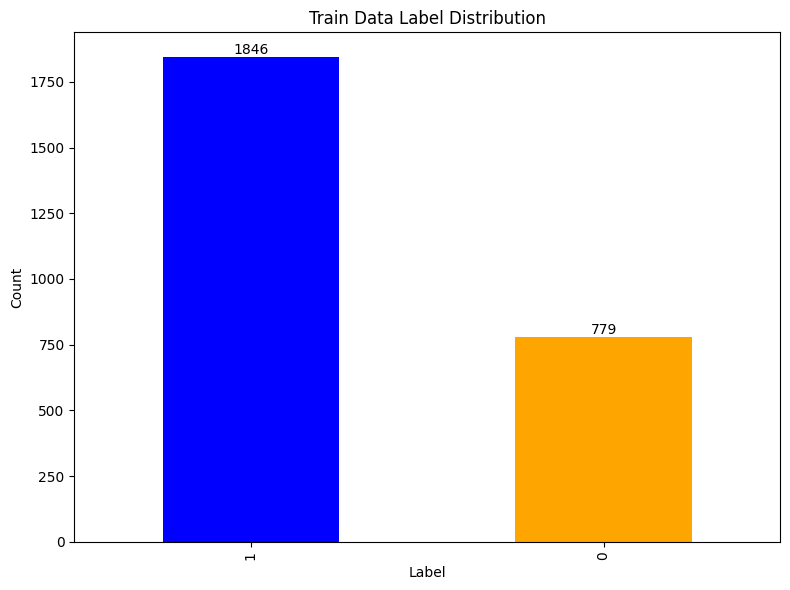

In [41]:
# Calculate label distribution for the entire train_data
train_label_distribution = train_data['label'].value_counts()

# Print label distribution
print("Label distribution for train data:")
print(train_label_distribution)

# Plot bar chart for train data label distribution
plt.figure(figsize=(8, 6))
train_label_distribution.plot(kind='bar', color = ['blue', 'orange'])  # Using default color
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Train Data Label Distribution')

# Add label counts on top of the bars
for i, v in enumerate(train_label_distribution):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [42]:
train_data = train_data.drop(columns=['order_id', 'order_id_cat'])
test_data = test_data.drop(columns=['order_id', 'order_id_cat'])
train_data = train_data.dropna()

In [43]:
train_data

,service_type_GO_FOOD,service_type_GO_RIDE,driver_status_AVAILABLE,driver_status_OTW_DROPOFF,driver_status_OTW_PICKUP,driver_status_UNAVAILABLE,label,unavailable_count,latitude_mean,latitude_median,latitude_min,latitude_max,longitude_mean,longitude_median,longitude_min,longitude_max,speed_mean,speed_median,speed_min,speed_max,distance_mean,distance_median,distance_min,distance_max,accuracy_in_meters_mean,accuracy_in_meters_median,accuracy_in_meters_min,accuracy_in_meters_max,otw_pickup_time_mean,otw_pickup_time_median,otw_pickup_time_min,otw_pickup_time_max,lat_rate_mean,lat_rate_median,lat_rate_min,lat_rate_max,lon_rate_mean,lon_rate_median,lon_rate_min,lon_rate_max
0,True,False,True,False,False,False,1,2,-6.876199,-6.874607,-6.881138,-6.870253,107.604297,107.604420,107.603595,107.605640,4.563838,0.000000,0.0,428.459153,0.014404,0.000000,0.0,1.124001,2.550590,0.1000,0.100,8.292,341.0,341.0,341.0,341.0,-0.000001,0.0,-0.001069,0.000089,1.780660e-07,0.000000e+00,-0.000060,0.000025
1,True,False,True,False,False,False,1,2,-6.878332,-6.877040,-6.886351,-6.876958,107.550013,107.550101,107.548632,107.550883,4.803286,0.051362,0.0,201.889912,0.014588,0.000143,0.0,0.841208,5.220178,5.4400,0.010,35.213,1484.0,1484.0,1484.0,1484.0,-0.000002,0.0,-0.000085,0.000496,-4.716890e-07,0.000000e+00,-0.000060,0.000095
2,True,False,False,False,False,True,1,2,-6.884306,-6.884925,-6.895647,-6.877353,107.614044,107.613587,107.612832,107.619610,2.346316,0.000000,0.0,179.201771,0.008895,0.000000,0.0,1.194678,4.217635,4.4510,0.100,57.281,2100.0,2100.0,2100.0,2100.0,0.000004,0.0,-0.000022,0.000447,2.183158e-06,0.000000e+00,-0.000014,0.000066
3,True,False,False,True,False,False,0,0,-6.929476,-6.928530,-6.937335,-6.925027,107.650355,107.647077,107.645635,107.662012,11.974497,2.736534,0.0,58.303191,0.032508,0.008613,0.0,0.125170,4.906231,3.9000,3.900,23.848,701.0,701.0,701.0,701.0,0.000008,0.0,-0.000067,0.000094,-1.482305e-05,0.000000e+00,-0.000144,0.000049
4,True,False,True,False,False,False,1,1,-6.916037,-6.917169,-6.917859,-6.908527,107.658783,107.656172,107.656001,107.667334,7.605590,0.092380,0.0,64.112441,0.032689,0.000257,0.0,1.389103,2.651331,3.0000,0.500,10.506,160.0,160.0,160.0,160.0,0.000006,0.0,-0.000096,0.000145,4.715265e-06,0.000000e+00,-0.000133,0.000090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3493,False,True,True,False,False,False,1,1,-6.900032,-6.899854,-6.903813,-6.897193,107.524218,107.520531,107.518217,107.537913,12.111291,2.401266,0.0,59.601340,0.033657,0.007202,0.0,0.165559,78.379762,14.6595,3.000,1200.000,380.0,380.0,380.0,380.0,-0.000002,0.0,-0.000075,0.000086,1.381164e-05,0.000000e+00,-0.000100,0.000140
3495,False,True,True,False,False,False,0,0,-6.885959,-6.885067,-6.893983,-6.879352,107.620827,107.616097,107.608738,107.638382,8.840485,1.879169,0.0,96.675410,0.024632,0.005121,0.0,0.360807,6.518141,6.1830,4.321,13.619,2010.0,2010.0,2010.0,2010.0,-0.000005,0.0,-0.000088,0.000067,1.031083e-05,6.000000e-07,-0.000067,0.000243
3497,False,True,False,False,True,False,0,0,-6.876333,-6.876692,-6.887798,-6.867222,107.550153,107.549719,107.534560,107.561653,17.715276,4.911281,0.0,214.723456,0.060868,0.016896,0.0,0.427414,26.659064,14.0000,4.000,1100.000,160.0,160.0,160.0,160.0,-0.000008,0.0,-0.000493,0.000095,-1.235509e-05,0.000000e+00,-0.000213,0.000109
3498,False,True,True,False,False,False,0,1,-6.938204,-6.940220,-6.941881,-6.931107,107.643698,107.645609,107.639016,107.645959,9.108314,2.141495,0.0,42.327250,0.025354,0.005949,0.0,0.117576,4.209821,3.9000,3.000,65.165,270.0,270.0,270.0,270.0,-0.000004,0.0,-0.000101,0.000085,2.248434e-07,0.000000e+00,-0.000074,0.000103


In [44]:
# Feature and target for train and test sets
X_train = train_data.drop(columns=['label'])
y_train = train_data['label']
X_test = test_data.drop(columns=['label'])
y_test = test_data['label']

In [45]:
X_train.columns

Index(['service_type_GO_FOOD', 'service_type_GO_RIDE',
       'driver_status_AVAILABLE', 'driver_status_OTW_DROPOFF',
       'driver_status_OTW_PICKUP', 'driver_status_UNAVAILABLE',
       'unavailable_count', 'latitude_mean', 'latitude_median', 'latitude_min',
       'latitude_max', 'longitude_mean', 'longitude_median', 'longitude_min',
       'longitude_max', 'speed_mean', 'speed_median', 'speed_min', 'speed_max',
       'distance_mean', 'distance_median', 'distance_min', 'distance_max',
       'accuracy_in_meters_mean', 'accuracy_in_meters_median',
       'accuracy_in_meters_min', 'accuracy_in_meters_max',
       'otw_pickup_time_mean', 'otw_pickup_time_median', 'otw_pickup_time_min',
       'otw_pickup_time_max', 'lat_rate_mean', 'lat_rate_median',
       'lat_rate_min', 'lat_rate_max', 'lon_rate_mean', 'lon_rate_median',
       'lon_rate_min', 'lon_rate_max'],
      dtype='object')

In [46]:
X_train = train_data[['speed_mean', 'speed_median', 'speed_min', 'speed_max', "unavailable_count",
        "latitude_mean",
        "latitude_median",
        "latitude_min",
        "latitude_max",
        "longitude_mean",
        "longitude_median",
        "longitude_min",
        "longitude_max","accuracy_in_meters_min"]]
X_test = test_data[['speed_mean', 'speed_median', 'speed_min', 'speed_max',   "unavailable_count",
        "latitude_mean",
        "latitude_median",
        "latitude_min",
        "latitude_max",
        "longitude_mean",
        "longitude_median",
        "longitude_min",
        "longitude_max","accuracy_in_meters_min"]]

## Logistic Regression without Sampling

Cross-validation scores:
fit_time: 0.06855716705322265
score_time: 0.022929859161376954
test_acc: 0.7268830591373945
test_prec_macro: 0.6628169199402069
test_rec_macro: 0.5997644378696669
test_f1_macro: 0.6043668616451106

Binary Cross-Entropy Loss for Train Set: 0.5010994979151017
Final Binary Cross-Entropy Loss for Test Set: 0.5574754478690356

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.35      0.43       260
           1       0.76      0.88      0.82       615

    accuracy                           0.72       875
   macro avg       0.65      0.61      0.62       875
weighted avg       0.70      0.72      0.70       875

Accuracy: 0.7211428571428572
Precision: 0.7616361071932299
Recall: 0.8780487804878049
AUC-ROC: 0.6140243902439024


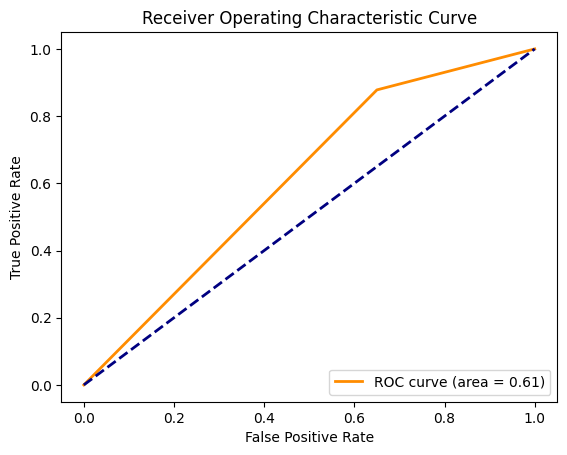

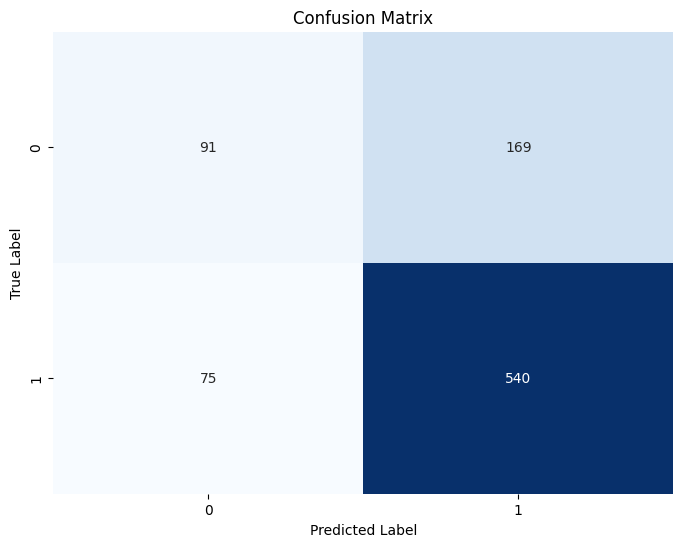

In [65]:
# Define multiple scoring metrics for cross-validation
scoring = {
    'acc': 'accuracy',
    'prec_macro': 'precision_macro',
    'rec_macro': 'recall_macro',
    'f1_macro': 'f1_macro'
}

# Pipeline for logistic regression with standard scaling
pipe = make_pipeline(StandardScaler(), LogisticRegression())

# Stratified K-Fold for cross-validation
stratkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and print scores
cv_scores = cross_validate(pipe, X_train, y_train, cv=stratkfold, scoring=scoring)
print("Cross-validation scores:")
for score in cv_scores:
    print(f"{score}: {cv_scores[score].mean()}")

# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

# Extract the logistic regression model from the pipeline
model = pipe.named_steps['logisticregression']

# Predictions on the training set
y_train_pred = pipe.predict(X_train)
y_train_proba = pipe.predict_proba(X_train)[:, 1]  # Probability predictions for log loss

# Predictions on the test set
y_pred = pipe.predict(X_test)
y_test_proba = pipe.predict_proba(X_test)[:, 1]  # Probability predictions for log loss


X_test_with_pred = X_test.copy()
X_test_with_pred['original_label'] = y_test
X_test_with_pred['predicted_label'] = y_pred

combined_test_data = X_test_with_pred

# Binary Cross-Entropy Loss for the Train and Test Set
bce_loss_train = log_loss(y_train, y_train_proba)
bce_loss_test = log_loss(y_test, y_test_proba)

# Evaluation metrics
print("\nBinary Cross-Entropy Loss for Train Set:", bce_loss_train)
print("Final Binary Cross-Entropy Loss for Test Set:", bce_loss_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Accuracy, Precision, Recall, AUC-ROC
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nAUC-ROC: {auc_roc}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Logistic Regression with Regularisation

Cross-validation scores:
fit_time: 0.07374114990234375
score_time: 0.023070573806762695
test_acc: 0.726495479472358
test_prec_macro: 0.6634555370168795
test_rec_macro: 0.591881565836382
test_f1_macro: 0.5938548454200031

Binary Cross-Entropy Loss for Train Set: 0.5019163589932485
Final Binary Cross-Entropy Loss for Test Set: 0.5565861613996562

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.32      0.40       260
           1       0.75      0.88      0.81       615

    accuracy                           0.71       875
   macro avg       0.64      0.60      0.60       875
weighted avg       0.69      0.71      0.69       875

Accuracy: 0.7142857142857143
Precision: 0.753120665742025
Recall: 0.8829268292682927
AUC-ROC: 0.7897310819262038


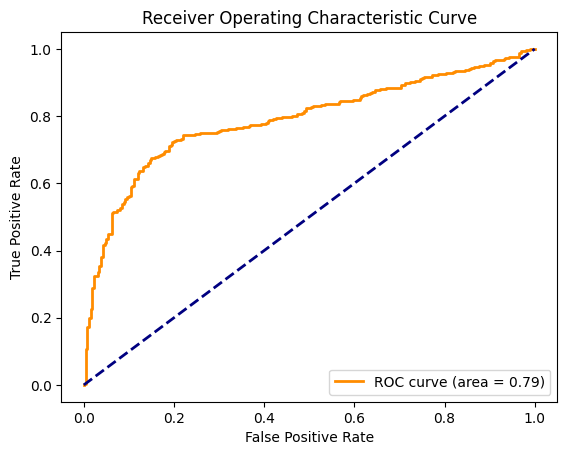

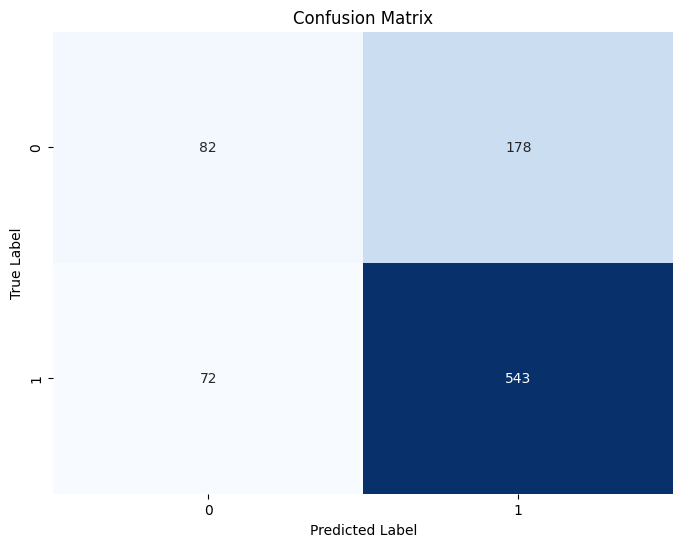

In [49]:
# Define multiple scoring metrics for cross-validation
scoring = {
    'acc': 'accuracy',
    'prec_macro': 'precision_macro',
    'rec_macro': 'recall_macro',
    'f1_macro': 'f1_macro'
}

# Pipeline for logistic regression with standard scaling and L2 regularization
C_value = 0.1  # Example value, adjust based on your needs
pipe = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', C=C_value))

# Stratified K-Fold for cross-validation
stratkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and print scores
cv_scores = cross_validate(pipe, X_train, y_train, cv=stratkfold, scoring=scoring)
print("Cross-validation scores:")
for score in cv_scores:
    print(f"{score}: {cv_scores[score].mean()}")

# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

# Predictions on the training and test sets
y_train_pred = pipe.predict(X_train)
y_train_proba = pipe.predict_proba(X_train)[:, 1]  # Probability predictions for log loss
y_pred = pipe.predict(X_test)
y_test_proba = pipe.predict_proba(X_test)[:, 1]  # Probability predictions for log loss

# Binary Cross-Entropy Loss for the Train and Test Sets
bce_loss_train = log_loss(y_train, y_train_proba)
bce_loss_test = log_loss(y_test, y_test_proba)

# Evaluation metrics
print("\nBinary Cross-Entropy Loss for Train Set:", bce_loss_train)
print("Final Binary Cross-Entropy Loss for Test Set:", bce_loss_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Accuracy, Precision, Recall, AUC-ROC
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_test_proba)  # Notice change to use probabilities
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nAUC-ROC: {auc_roc}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)  # Notice change to use probabilities
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Logistic Regression with SMOTE

Cross-validation scores (SMOTE):
acc: 0.7557744182599675
prec_macro: 0.7343946184349027
rec_macro: 0.777401465194407
f1_macro: 0.7369747871333663

Binary Cross-Entropy Loss for Train Set: 0.5685566726017012
Final Binary Cross-Entropy Loss for Test Set: 0.6419659947132266

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.86      0.67       260
           1       0.92      0.71      0.80       615

    accuracy                           0.75       875
   macro avg       0.74      0.78      0.74       875
weighted avg       0.81      0.75      0.76       875

Accuracy: 0.7508571428571429
Precision: 0.921443736730361
Recall: 0.7056910569105691
AUC-ROC: 0.7816916823014385


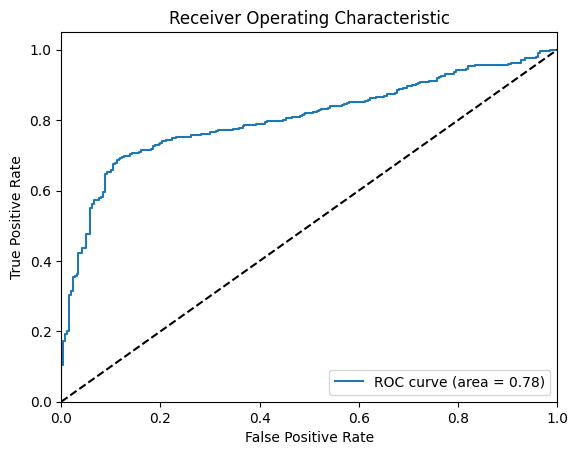

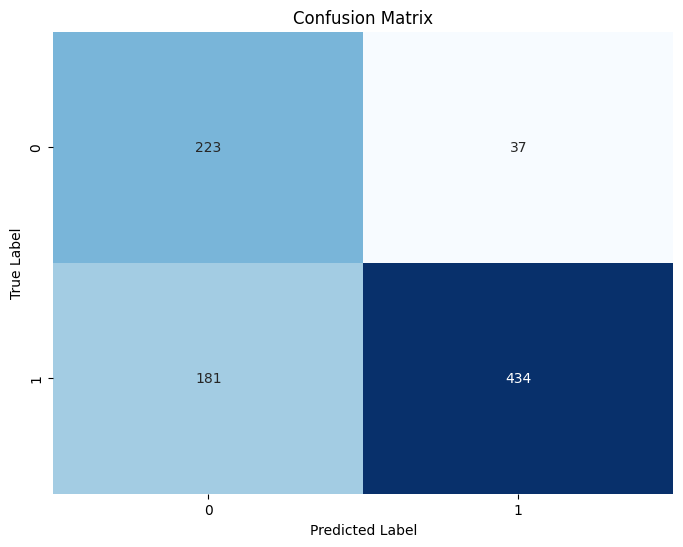

In [50]:
# Define scoring metrics for evaluation
scoring = {
    'acc': 'accuracy',
    'prec_macro': 'precision_macro',
    'rec_macro': 'recall_macro',
    'f1_macro': 'f1_macro'
}

# SMOTE with Logistic Regression
smote_pipe = IMBPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('log_reg', LogisticRegression(class_weight='balanced', random_state=42))
])

# Choose the model you want to use: smote_pipe or penalized_log_reg
model = smote_pipe  # or penalized_log_reg for the penalized model

# Stratified K-Fold for cross-validation
stratkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_validate(model, X_train, y_train, cv=stratkfold, scoring=scoring)
print("Cross-validation scores (SMOTE):")
for score in scoring:
    print(f"{score}: {cv_scores['test_' + score].mean()}")

# Fit the model
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_train_proba = model.predict_proba(X_train)[:, 1]  # Probability predictions for log loss
y_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]

# Binary Cross-Entropy Loss
bce_loss_train = log_loss(y_train, y_train_proba)
bce_loss_test = log_loss(y_test, y_test_proba)

# Evaluation
print("\nBinary Cross-Entropy Loss for Train Set:", bce_loss_train)
print("Final Binary Cross-Entropy Loss for Test Set:", bce_loss_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Accuracy, Precision, Recall, AUC-ROC
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nAUC-ROC: {auc_roc}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [51]:
from sklearn.metrics.pairwise import cosine_similarity

# Assuming X_train contains the features and y_train contains the labels
# Normalize X_train for cosine similarity
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Calculate cosine similarity matrix
cos_sim_matrix = cosine_similarity(X_scaled)

# Convert to DataFrame for easier handling
cos_sim_df = pd.DataFrame(cos_sim_matrix)

# Identify pairs with high similarity but differing labels
# Set a threshold for high similarity, e.g., 0.9
threshold = 0.9
similar_pairs = []

for i in range(cos_sim_df.shape[0]):
    for j in range(i+1, cos_sim_df.shape[0]):
        if cos_sim_df.iloc[i, j] >= threshold and y_train.iloc[i] != y_train.iloc[j]:
            similar_pairs.append((i, j))

print(f"Found {len(similar_pairs)} pairs with similar features but differing labels.")

Found 45751 pairs with similar features but differing labels.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.3 MB/s eta 0:00:00


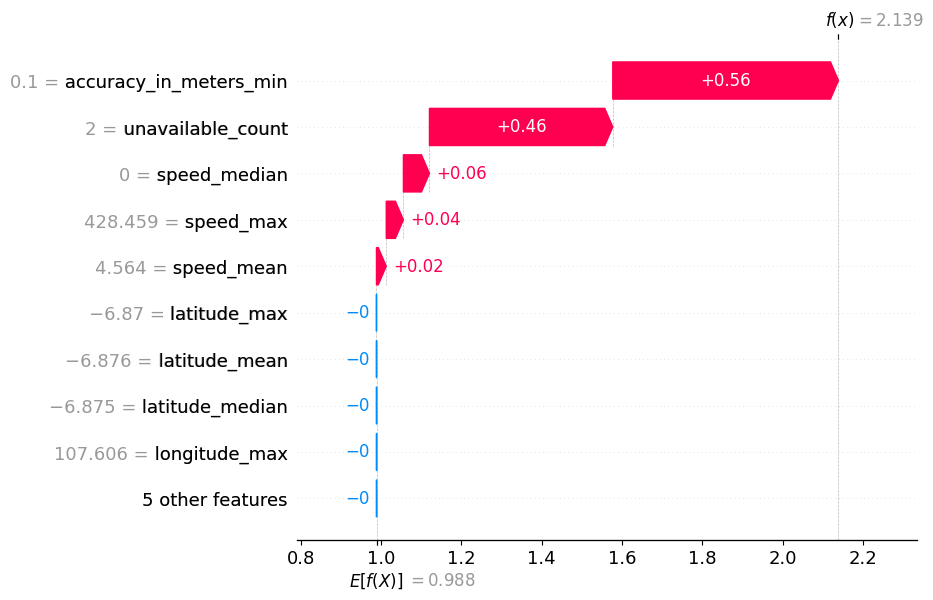

In [52]:
!pip install shap
import shap

# Fit the model on the training set
model = LogisticRegression().fit(X_train, y_train)

# Calculate SHAP values
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

# # Visualize the SHAP values for the first sample
shap.plots.waterfall(shap_values[0])
# Generate a summary plot for multiple predictions
# shap.summary_plot(shap_values, X_train)

In [66]:
# Fill NaN values with zeros
combined_test_data_filled = combined_test_data.fillna(0)

# Compute cosine similarity between rows
similarity_matrix = cosine_similarity(combined_test_data_filled.drop(columns=['predicted_label']))

# Find pairs of rows with contrasting predicted labels and high similarity
threshold = 0.9  # Adjust as needed
contrasting_pairs = []

for i in range(len(similarity_matrix)):
    for j in range(i + 1, len(similarity_matrix)):
        if (combined_test_data.iloc[i]['predicted_label'] != combined_test_data.iloc[j]['predicted_label'] and
            combined_test_data.iloc[i]['original_label'] == combined_test_data.iloc[j]['original_label'] and
            similarity_matrix[i][j] >= threshold):
            contrasting_pairs.append((i, j))


In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Third pair of rows with contrasting predicted labels and high similarity:")
if contrasting_pairs and len(contrasting_pairs) > 2:
    i, j = contrasting_pairs[2]  # Changed from [0] to [1] to access the second pair
    row_i = combined_test_data.iloc[i]
    row_j = combined_test_data.iloc[j]
    print("Pair:")
    print("Row", i, ":", row_i.to_dict())
    print("Row", j, ":", row_j.to_dict())
else:
    print("No sufficient contrasting pairs found with high similarity.")


Third pair of rows with contrasting predicted labels and high similarity:
Pair:
Row 0 : {'speed_mean': 4.245222172952441, 'speed_median': 0.01779946334368363, 'speed_min': 0.0, 'speed_max': 68.18154311254322, 'unavailable_count': 0.0, 'latitude_mean': -6.863818734177215, 'latitude_median': -6.8640087, 'latitude_min': -6.8643023, 'latitude_max': -6.8613375, 'longitude_mean': 107.57134109493671, 'longitude_median': 107.5718273, 'longitude_min': 107.565867, 'longitude_max': 107.571852, 'accuracy_in_meters_min': 13.715, 'original_label': 1.0, 'predicted_label': 0.0}
Row 3 : {'speed_mean': 3.380165061152039, 'speed_median': 0.0, 'speed_min': 0.0, 'speed_max': 134.00010920778274, 'unavailable_count': 2.0, 'latitude_mean': -6.882811063047399, 'latitude_median': -6.881175, 'latitude_min': -6.8918008, 'latitude_max': -6.878718, 'longitude_mean': 107.60402170093244, 'longitude_median': 107.60358, 'longitude_min': 107.602369, 'longitude_max': 107.61352, 'accuracy_in_meters_min': 0.2, 'original_la

SHAP values for the third pair of rows with contrasting predicted labels and high similarity:
Row 0 : speed_mean                  4.245222
speed_median                0.017799
speed_min                   0.000000
speed_max                  68.181543
unavailable_count           0.000000
latitude_mean              -6.863819
latitude_median            -6.864009
latitude_min               -6.864302
latitude_max               -6.861338
longitude_mean            107.571341
longitude_median          107.571827
longitude_min             107.565867
longitude_max             107.571852
accuracy_in_meters_min     13.715000
original_label              1.000000
predicted_label             0.000000
Name: 5, dtype: float64


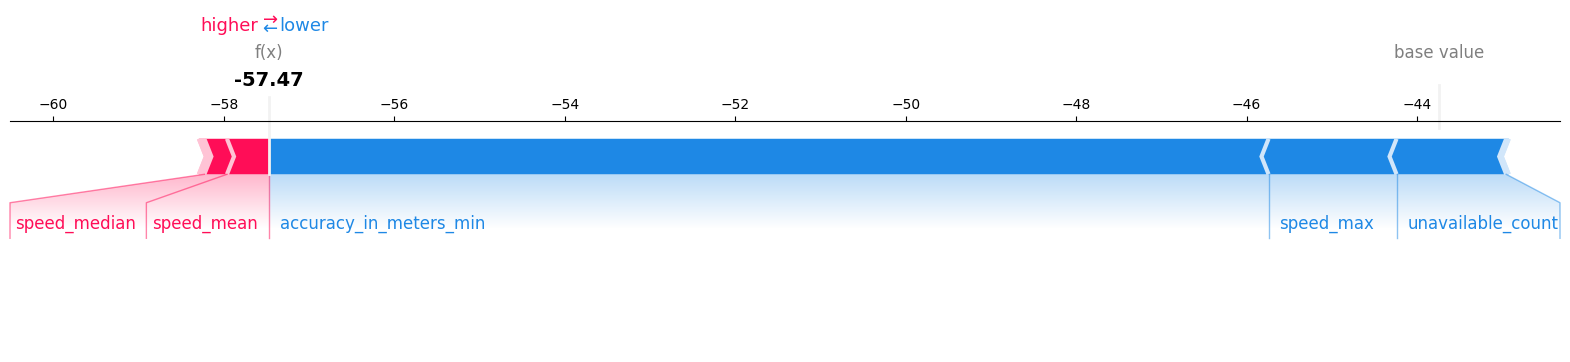

Row 2 : speed_mean                  3.380165
speed_median                0.000000
speed_min                   0.000000
speed_max                 134.000109
unavailable_count           2.000000
latitude_mean              -6.882811
latitude_median            -6.881175
latitude_min               -6.891801
latitude_max               -6.878718
longitude_mean            107.604022
longitude_median          107.603580
longitude_min             107.602369
longitude_max             107.613520
accuracy_in_meters_min      0.200000
original_label              1.000000
predicted_label             1.000000
Name: 13, dtype: float64


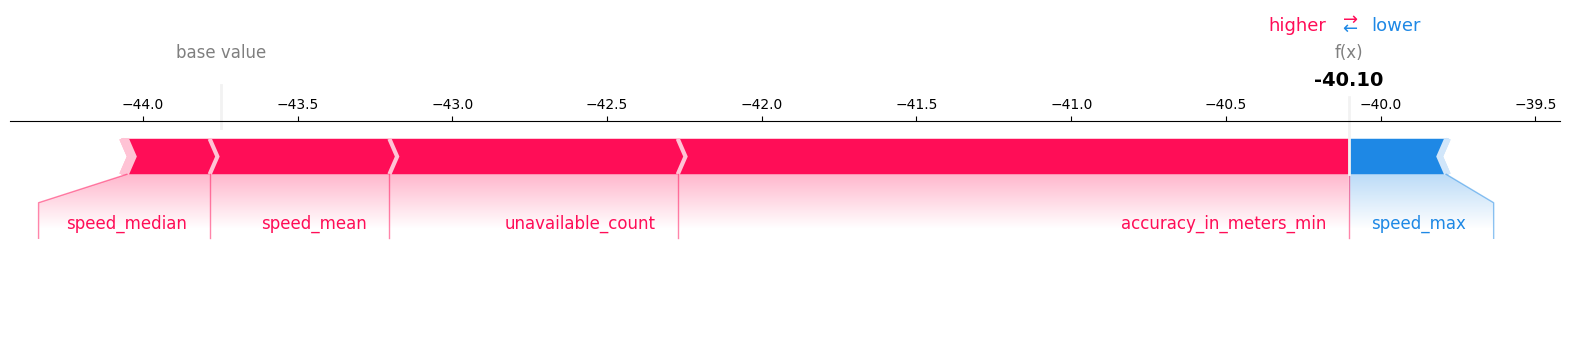

In [76]:
# Fit SHAP explainer
explainer = shap.Explainer(pipe.named_steps['logisticregression'], X_train)

# Compute SHAP values for the second pair
if contrasting_pairs and len(contrasting_pairs) > 1:  # Check if there is at least a second pair
    i, j = contrasting_pairs[2]  # Change from [0] to [1] to use the second pair
    instances = combined_test_data.iloc[[i, j]]
    shap_values_instances = explainer.shap_values(instances.drop(columns=['original_label', 'predicted_label']))

    # Visualize SHAP values for the second pair
    print("SHAP values for the third pair of rows with contrasting predicted labels and high similarity:")
    for idx, shap_values_instance in enumerate(shap_values_instances):
        print("Row", contrasting_pairs[1][idx], ":", instances.iloc[idx])  # Updated index to [1]
        shap.force_plot(explainer.expected_value, shap_values_instance, feature_names=instances.drop(columns=['original_label', 'predicted_label']).columns, matplotlib=True)
        plt.show()
else:
    print("No sufficient contrasting pairs found with high similarity.")
